# Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications**<br>
12.03.2023<br>
Erik Holopainen, Alejandro Rosales Rodriguez and Brian van den Berg<br>
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

Instructions: Write here why this Notebook was created, what were the main objectives.

## 2. Setup

Instructions: Write here shortly what libraries were used and why.

In [1]:
# Machine Learning and Data Science
import pandas as pd
import numpy as np
import nltk

# Modeling neural networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt

# General imports
import sys
import os

# Print the library versions
print('\033[1m' + 'Notebook Version Register:' + '\033[0m')
print(f'[Python {sys.version}]')
print(f'[{tf.__name__} {tf.__version__}]')
print(f'[{pd.__name__} {pd.__version__}]')
print(f'[{np.__name__} {np.__version__}]')
print(f'[{nltk.__name__} {nltk.__version__}]')
print(f'[{sklearn.__name__} {sklearn.__version__}]')
print(f'[{matplotlib.__name__} {matplotlib.__version__}]')

Notebook Version Register:
[Python 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]]
[tensorflow 2.11.0]
[pandas 1.5.3]
[numpy 1.24.1]
[nltk 3.8.1]
[sklearn 1.2.0]
[matplotlib 3.6.3]


In [2]:
# Fetch the nltk datasets
# nltk.download('popular') # You only need to download it once

## 3. Dataset

Instructions: Describe here brielfy the data and its main characteristics. Remember document the code.  

In [3]:
# Define the input variables
inputDir = 'input'
inputPaths = []

# Get the .csv files in the input folder
for file in os.listdir(inputDir):
    if file.endswith('.csv'):
        inputPaths.append(os.path.join(inputDir, file))

# Print the input paths
print(inputPaths)

# Define the dataframe
df = pd.DataFrame()

# Append all the input files
for path in inputPaths:
    df = pd.concat([df, pd.read_csv(path)], ignore_index=True)

# Drop the unique id column
df = df.drop(['uniqueID'], axis=1)

# Shuffle the dataframe
df = df.sample(frac=1)
df = df.reset_index(drop=True)

# Display the dataframe
display(df)

# Display the dataframe description
print("Description of the dataframe:")
display(df.describe().T)

['input\\drugsComTest_raw.csv', 'input\\drugsComTrain_raw.csv']


,drugName,condition,review,rating,date,usefulCount
0,Lisinopril,High Blood Pressure,"""So far the medicine has been working well, wi...",10,19-Jun-14,70
1,Terbinafine,Tinea Cruris,"""Very comfortable and soothing. I would recomm...",9,11-Mar-08,25
2,Acetaminophen / oxycodone,Pain,"""Works great for me""",10,25-Feb-15,24
3,Propofol,Anesthesia,"""I had my first general anesthetic yesterday, ...",10,19-Mar-15,19
4,Ortho-Cept,Birth Control,"""I completely lost my sex drive. It&#039;s lik...",4,11-Dec-14,5
...,...,...,...,...,...,...
215058,Antabuse,Alcohol Dependence,"""Long story short...At the end I was drinking ...",9,18-Dec-09,117
215059,Sulfamethoxazole / trimethoprim,Bacterial Skin Infection,"""Was prescribed this after getting a boil drai...",5,20-Sep-15,11
215060,Dulcolax,Constipation,"""This product is strong. I mean STRONG. I only...",9,4-Feb-16,2
215061,Atarax,Pruritus,"""It has the desired effect of stopping the itc...",8,8-May-09,69


Description of the dataframe:


,count,mean,std,min,25%,50%,75%,max
rating,215063.0,6.990008,3.275554,1.0,5.0,8.0,10.0,10.0
usefulCount,215063.0,28.001004,36.346069,0.0,6.0,16.0,36.0,1291.0


## 4. Preprocessing

Instructions: Describe:

- how the missing values are handled
- conversion of textual and categorical data into numerical values (if needed)
- how the data is splitted into train, validation and test sets
- the features (=input) and labels (=output), and 
- how the features are normalized or scaled

### Splitting

In [4]:
# Get the reviews
X = list(df['review'])
y = list(df['rating'])

# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

### Lemmatization

In [5]:
# Define the nltk variables
en_stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to preprocess text
def prepare_sentence(text):
    text = text.lower()

    # Tokenize the text
    text = nltk.word_tokenize(text)
    
    # process all tokens aslong as they're alpha-numeric (text)
    result = []
    for token in text:
        if token not in en_stopwords and token.isalnum():
            token = lemmatizer.lemmatize(token)
            result.append(token)

    # Join the seperate strings back into a single string
    if len(result) > 0:
        text = result.pop(0)
        for word in result:
            text += ' ' + word
    else:
        text = ''

    return text

# lemmatize the training data
print('Example of lemmatization:')
print(X_train[0])
for i in range(len(X_train)):
    X_train[i] = prepare_sentence(X_train[i])
print(X_train[0])

Example of lemmatization:
"I&#039;m 28, no children. I&#039;ve been on this birth control for about 5 years and have just one complaint - it gives me high blood pressure. High BP runs in my family, so I am switching from this birth control to another one. Apart from the high BP, this birth control has been fantastic. My skin has never looked better, I didn&#039;t gain weight, nor did I experience mood swings. Occasionally I had spotting between periods, but it was never anything that disrupted me. I know everyone is different, but my experience was great."
039 28 child 039 birth control 5 year one complaint give high blood pressure high bp run family switching birth control another one apart high bp birth control fantastic skin never looked better 039 gain weight experience mood swing occasionally spotting period never anything disrupted know everyone different experience great


### Tokenization

In [6]:
# Maximum amount of words for the model to process (based on frequency)
unique_words = set()
for review in X_train:
    unique_words.update(set(word for word in review.strip().split()))
num_words = len(unique_words)
print(f'Number of different unique words in tokenizer: {num_words}')

# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Tokenize the reviews
X_train = tokenizer.texts_to_sequences(X_train)

Number of different unique words in tokenizer: 42533


### Padding

In [7]:
# Get the biggest sequence in the data
maxlen = 0
for seq in X_train:
    if len(seq) > maxlen:
        maxlen = len(seq)
print(f'Maximum words in a review: {maxlen}')

# Apply padding to make all sequences an equal size
X_train = np.array(pad_sequences(X_train, maxlen=maxlen))

Maximum words in a review: 564


### Pipeline

In [8]:
# Function to preprocess reviews
def prepare_text(data):
    for i in range(len(data)):
        data[i] = prepare_sentence(data[i])
    data = tokenizer.texts_to_sequences(data)
    data = np.array(pad_sequences(data, maxlen=maxlen))
    return data

### Simplify and Encode the Labels

In [9]:
# Simplification function
def simplify(num):
    if num < 5:
        return 0
    elif num > 6:
        return 2
    else:
        return 1

# Simplify the labels
y_train = np.array(list(map(simplify, y_train)))

# Calculate the class weights
total = len(y_train)
unique, counts = np.unique(y_train, return_counts=True)

# Encode the labels for multi classification
y_train = np.array(to_categorical(y_train))

# Print the distribution
print(f'The unique labels are: [{unique[0]}, {unique[1]}, {unique[2]}] with a distribution of [{counts[0]}, {counts[1]}, {counts[2]}].')

# Create a function to prepare labels for the model
def prepare_labels(labels):
    labels = np.array(list(map(simplify, labels)))
    labels = np.array(to_categorical(labels))
    return labels

The unique labels are: [0, 1, 2] with a distribution of [34395, 12275, 90970].


## 5. Modeling

Instructions: Write a short description of the model: 

- selected loss, optimizer and metrics settings, and 
- the summary of the selected model architecture. 

In [32]:
# Create an LSTM model
model = Sequential([
    Embedding(num_words + 1, 4, input_length=maxlen),
    LSTM(32, dropout=.1, recurrent_dropout=.1),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy'])

# Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 564, 4)            170136    
                                                                 
 lstm_2 (LSTM)               (None, 32)                4736      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 174,971
Trainable params: 174,971
Non-trainable params: 0
_________________________________________________________________


## 6. Training

Instructions: Write a short description of the training process, and document the code for training and the total time spend on it. 

In [30]:
# Prepare the validation data
X_val = prepare_text(X_val)
y_val = prepare_labels(y_val)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [33]:
# Model Fitting
history = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/10
195/538 [=========>....................] - ETA: 6:37 - loss: 0.8160 - Accuracy: 0.6679

KeyboardInterrupt: 

## 7. Performance and evaluation

Instructions: 

- Show the training and validation loss and accuracy plots
- Interpret the loss and accuracy plots (e.g. is there under- or over-fitting)
- Describe the final performance of the model with test set 

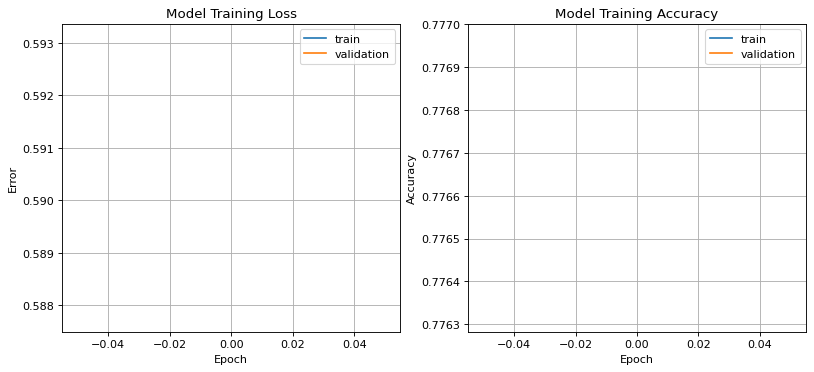

In [22]:
# Define a function to plot the loss curve
def plotLoss(h, name):
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='validation')
    plt.title('{0} Training Loss'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

# Plot the Accuracy curve
def plotAccuracy(h, name):
    plt.plot(h.history['Accuracy'], label='train')
    plt.plot(h.history['val_Accuracy'], label='validation')
    plt.title('{0} Training Accuracy'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Define the sub-plot size
nCols = 2
nRows = 1

# Prepare the Loss Plots
plt.figure(figsize=(nCols * 6, nRows * 5), dpi=80)

# Plot the Loss
plt.subplot(nRows, nCols, 1)
plotLoss(history, 'Model')

# Plot the Accuracy
plt.subplot(nRows, nCols, 2)
plotAccuracy(history, 'Model')

# Draw the plots
plt.show()



## 8. Discussion and conclusions

Instructions: Write

- What settings and models were tested before the best model was found
    - What where the results of these experiments 
- Summary of  
    - What was your best model and its settings 
    - What was the final achieved performance 
- What are your main observations and learning points
- Discussion how the model could be improved in future 

**Note:** Remember to evaluate the final metrics using the test set. 
